In [1]:
use_gdrive = True # @param {type:"boolean"}

RESULTS_PATH = "results2"

if use_gdrive:
  try:
    # mount your google drive to get permanent storage for your results
    from google.colab import drive
    drive.mount('/content/drive')

    RESULTS_PATH = "/content/drive/MyDrive/infoseclab23/results2"
  except ModuleNotFoundError:
    print("failed to mount gdrive")
else:
  print(f"saving results to '{RESULTS_PATH}'. If you're using Google Colab, this folder will be deleted when you disconnect!")

!mkdir -p {RESULTS_PATH}

Mounted at /content/drive


In [2]:
import sys

# Lab files
![ ! -d 'infoseclab_23' ] && git clone https://github.com/ethz-spylab/infoseclab_23.git
%cd infoseclab_23
!git pull https://github.com/ethz-spylab/infoseclab_23.git
%cd ..
if "infoseclab_23" not in sys.path:
  sys.path.append("infoseclab_23")

Cloning into 'infoseclab_23'...
remote: Enumerating objects: 34, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 34 (delta 0), reused 2 (delta 0), pack-reused 30
Receiving objects: 100% (34/34), 268.09 MiB | 68.27 MiB/s, done.
Resolving deltas: 100% (1/1), done.
/content/infoseclab_23
From https://github.com/ethz-spylab/infoseclab_23
 * branch            HEAD       -> FETCH_HEAD
Already up to date.
/content


# Imports

In [3]:
import infoseclab
from infoseclab import ShadowModels, utils, evaluation
import matplotlib.pyplot as plt
import numpy as np
import os
import pathlib
import scipy
import sklearn
import warnings
from zipfile import ZipFile
import torch

from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
from collections import Counter

# Membership Inference

In this part of the lab, you will create a membership inference attack, with a twist:
you do not know which shadow models were trained on which samples.

First, load the predictions.

In [4]:
# Load data
activations_fit = ShadowModels.activations_fit        # pre-softmax activations from shadow models to construct your attack (50000 x 127 x 10)
activations_attack = ShadowModels.activations_attack  # pre-softmax activations from the target model to attack (50000 x 10)
labels = ShadowModels.labels                          # the class labels of all samples (50000)
training_splits = ShadowModels.training_splits        # train-test vector; -1 for test samples, 1/0 (member/non-member) for training samples (50000)

num_samples, num_models, num_classes = activations_fit.shape
assert activations_attack.shape == (num_samples, num_classes)
assert labels.shape == (num_samples,)
assert training_splits.shape == (num_samples,)

# Mask that is True for all samples with a known target membership label
training_mask = (training_splits != -1)

**Implement your membership inference attack in the following cell.**

Remember that your output should be a NumPy array
containing attack scores for *all* samples,
but we only consider samples where the corresponding `training_mask` entry
is `False` for grading.

The following code performs a dummy attack that ignores all shadow model outputs.

In [44]:
def change_logits_form(orig_logits):
  #calculate the processed logits(l)
  logits = np.zeros_like(orig_logits)
  for i in range(num_classes):
    #mask:num_samples, num_models, num_classes
    #using the mask to calculate logits of each class
    mask_y = np.zeros_like(orig_logits)
    mask_y[:, :, i] = 1
    mask_y_prime = abs(mask_y - 1)
    y_logits = (orig_logits * mask_y).max(axis=2)
    y_prime_logits = (orig_logits * mask_y_prime).max(axis=2)
    logits[:, :, i] = y_logits - y_prime_logits

  return logits

def disentangle_with_gaussian(logits):
  rng = np.random.default_rng(seed=0)

  gmm = GaussianMixture(n_components=2, random_state=rng.integers(0, 5), covariance_type='tied', init_params='k-means++')

  logits = np.expand_dims(logits, axis=1)

  gmm.fit(logits)

  means = gmm.means_.reshape(2)
  #two distributions share the common std
  std = np.sqrt(gmm.covariances_).reshape(-1)
  stds =[std[0], std[0]]

  #change the out, in distribution
  if means[0] > means[1]:
    means = [means[1], means[0]]

  return means, stds

def get_prob(x, mean, std):
  #calculate the probability given x
  prob = scipy.stats.norm.pdf(x, mean, std)
  return prob

#change logits form from z to ln(p / (1 - p))
all_orig_logits = np.concatenate((activations_fit, np.expand_dims(activations_attack, axis=1)), axis=1)
logits = change_logits_form(all_orig_logits)

#pick the corresponding logits for each sample
label_indices = np.expand_dims(np.expand_dims(labels, axis=1).repeat(num_models + 1, axis=1), axis=2)
label_logits = np.take_along_axis(logits, label_indices, axis=2)
label_logits = label_logits.reshape(num_samples, -1)

#get target_model and shadow model logits
target_logits = label_logits[:, -1]
shadow_logits = label_logits[:, :-1]

#for each sample calculate the ratio
ratios = []
for i in range(num_samples):
  l = target_logits[i]
  logits = shadow_logits[i]

  means, stds = disentangle_with_gaussian(logits)

  in_probability = get_prob(l, means[1], stds[1])
  out_probability = get_prob(l, means[0], stds[0])

  if out_probability == 0:
    out_probability += 1e-10

  assert out_probability != 0

  ratio = in_probability / out_probability

  ratios.append(ratio)

# TODO: Replace the following dummy score with your attack
attack_scores = np.array(ratios, dtype=np.float32)

# Save scores
utils.save_attack_scores(os.path.join(RESULTS_PATH, "attack_scores.npy"), attack_scores)

Dummy attack TPR @ FPR 1.00%: 12.72%


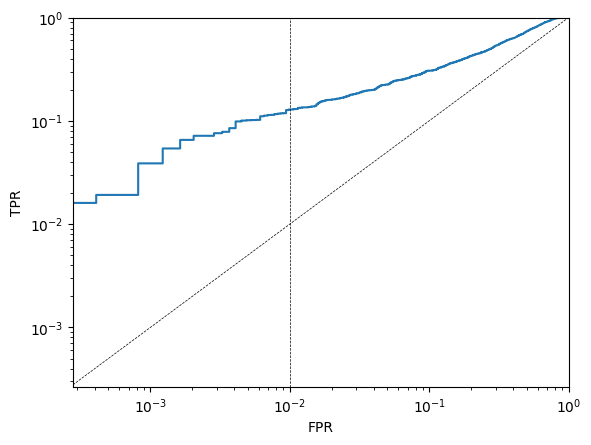

In [45]:
# You can visualize the TPR vs. FPR of your attack on the training set using the following code.
# If you want to evaluate multiple attacks you can call `evaluation.eval_mia` multiple times,
# but you should set `plot_decorations = False` for all but the first call.
fig, ax = plt.subplots()
evaluation.eval_mia(
    true_splits=training_splits[training_mask],
    attack_scores=attack_scores[training_mask],
    ax=ax,
    label="Dummy attack",
    plot_decorations=True,
)
plt.show(fig)
plt.close(fig)

# Stealing Chatbot Prompts

Enter results for the chatbot secret extraction

In [48]:
# Enter your 10 extracted secrets, 6 alphanumeric characters each
secrets = [
    "TIOsxG",
    "ur71Ct",
    "x7yQxM",
    "3PiGUk",
    "TZoP2i",
    "NofQK8",
    "6gTiO0",
    "pss410",
    "j7xE6h",
    "hmaPiB"
]

# save the secrets to an array and save it to chatbot.npy
secrets = np.array(secrets)
assert len(secrets) == 10
np.save(f"{RESULTS_PATH}/chatbot.npy", secrets)

# Create submission file (**upload `results2.zip` to moodle**)

In [49]:
!zip -j -FSr "{RESULTS_PATH}/results2.zip" {RESULTS_PATH}

  adding: chatbot.npy (deflated 52%)


In [50]:
from infoseclab.submission import validate_zip2
assert validate_zip2(f"{RESULTS_PATH}/results2.zip")

Zip file is valid
